In [ ]:
#Code for improved fMRI-bias learning
#OV Jan 2021
####IMPORTS
import tensorflow as tf
import socket
import neurite as ne
import neurite_sandbox as nes
import numpy as np
import keras
import freesurfer as fs
from keras.optimizers import Adam
from keras import backend as K
from keras import layers as KL
#Load my own functions
import my_utils as utils
#from freesurfer import deeplearn as fsd
#OV: This imports all the local settings, e.g. subjects etc. from the header.py and netparms.py file, make your changes in there as needed
from netparms import *
from header_better import *
import losspad
#OV add matplotlib for plotting and cross checks
#import matplotlib.pyplot as plt
import random as rd
import string as string
####END IMPORTS
tf.__version__

READ IN DATA


In [2]:
surfs_sphere   = np.load('data_train/surfs_sphere.npy',allow_pickle = "true")
surfs_pials    = np.load('data_train/surfs_pials.npy',allow_pickle = "true")
surfs_inflated = np.load('data_train/surfs_inflated.npy',allow_pickle = "true")
labels_cortex  = np.load('data_train/labels_cortex.npy',allow_pickle = "true")
maps_func      = np.load('data_train/maps_func.npy',allow_pickle = "true")
maps_func_mean = np.load('data_train/maps_func_mean.npy',allow_pickle = "true")
maps_angles    = np.load('data_train/maps_angles.npy',allow_pickle = "true")
maps_thickness = np.load('data_train/maps_thickness.npy',allow_pickle = "true")
maps_angio     = np.load('data_train/maps_angio.npy',allow_pickle = "true")
NumFuncs       = np.load('data_train/NumFuncs.npy',allow_pickle = "true")
%whos

Variable            Type       Data/Info
----------------------------------------
Adam                ABCMeta    <class 'tensorflow.python<...>.optimizer_v2.adam.Adam'>
Func_runs           list       n=10
K                   module     <module 'keras.backend' f<...>ckages/keras/backend.py'>
KL                  module     <module 'keras.layers' fr<...>eras/layers/__init__.py'>
NumFuncs            ndarray    10: 10 elems, type `float64`, 80 bytes
Veno_runs           list       n=7
batch_size          int        2
epochs              int        250
hemis               list       n=2
keras               module     <module 'keras' from '/cl<...>kages/keras/__init__.py'>
labels_cortex       ndarray    7x2x256x512: 1835008 elems, type `float32`, 7340032 bytes (7.0 Mb)
learning_rate       float      0.0001
losspad             module     <module 'losspad' from '/<...>/Better_code/losspad.py'>
maps_angio          ndarray    7x2x256x512: 1835008 elems, type `float32`, 7340032 bytes (7.0 Mb)
maps_

Define in and ouput data and assign a cortex label if wanted:

In [3]:
numInputs = 4
#Percentile for removal of outliers
percentiles = [3,97]
#Assign in- and output data
inputs  = []
outputs = [] 
input_shape  = (maps_thickness[0][0].shape+(numInputs,))

for sno, subject in enumerate(subjects): 
   for hno, hemi in enumerate(hemis):
      for rn, func_runs in enumerate(Func_runs):
         if numInputs > 1:
            #We don't have a full set of runs for all subjects, some didn't register well
            #also multiply by cortex label 
            tmp_in = np.zeros(input_shape)
            try:
               #remove outliers and then normalise fluctuations and multiply by 100 
               #tmp = np.multiply(maps_func[sno][hno][rn].data,labels_cortex[sno][hno])
               tmp = np.multiply(maps_func_mean[sno][hno].data,labels_cortex[sno][hno])
               tmp = utils.zero_outliers_image(tmp,percentiles)
               tmp = utils.normalize_image(tmp)*100
               outputs.append(tmp)
               tmp_in[...,0] = np.multiply(maps_thickness[sno][hno].data,labels_cortex[sno][hno])
               tmp_in[...,1] = np.multiply(maps_angio[sno][hno].data,labels_cortex[sno][hno])
               tmp_in[...,2] = np.multiply(maps_angles[sno][hno][rn].data,labels_cortex[sno][hno])
               tmp_in[...,3] = np.multiply(maps_func[sno][hno][rn].data,labels_cortex[sno][hno])
               inputs.append(tmp_in)
            except IndexError:
               continue
         elif numInputs == 1:
            try: 
               #remove outliers and then normalise fluctuations and multiply by 100 
               #tmp = np.multiply(maps_func[sno][hno][rn].data,labels_cortex[sno][hno])
               tmp = np.multiply(maps_func_mean[sno][hno].data,labels_cortex[sno][hno])
               tmp = utils.zero_outliers_image(tmp,percentiles)
               tmp = utils.normalize_image(tmp)*100
               outputs.append(tmp)
               #inputs.append(np.multiply(maps_angio[sno][hno].data,labels_cortex[sno][hno]))
               #inputs.append(np.multiply(maps_angles[sno][hno][rn].data,labels_cortex[sno][hno]))
               #inputs.append(np.multiply(maps_thickness[sno][hno].data,labels_cortex[sno][hno]))
               inputs.append(np.multiply(maps_func[sno][hno][rn].data,labels_cortex[sno][hno]))
            except IndexError:
               continue  
print(NumFuncs)


[20.000 20.000 20.000 12.000 20.000 18.000 18.000 0.000 0.000 0.000]


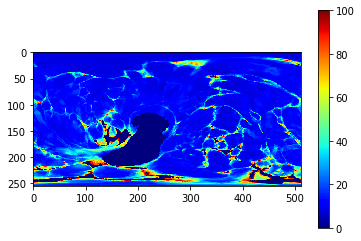

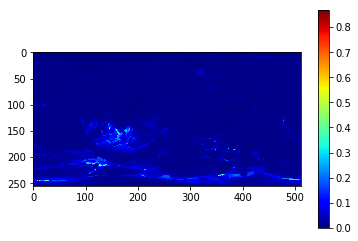

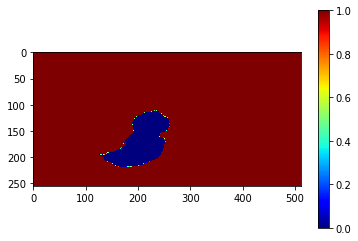

In [7]:
#im = utils.zero_outliers_image(maps_func_mean[4][0].data,percentiles)
plt.figure()
plt.imshow(tmp, cmap = 'jet')
plt.colorbar()
plt.figure()
plt.imshow(maps_func[0][1][5], cmap = 'jet')
plt.colorbar()
plt.figure()
plt.imshow(labels_cortex[0][1], cmap = 'jet')
plt.colorbar()

Circuarly leave-on-out strategy for training and testing

In [ ]:
epochs        = 80
learning_rate = 1e-3
use_mask      = True

#Initialize
loss           = []
val_loss       = []
Prediction_err = []
NullOutput_err = []
NullInput_err  = []
plt.figure()

NumFuncs    = NumFuncs.astype(int)
CumSumFuncs = np.cumsum(NumFuncs)
for subj, subject in enumerate(subjects):
   target_shape = (maps_func[0][0][0].shape+(1,)) 
   input_shape  = (maps_thickness[0][0].shape+(numInputs,))
   print('subject: %s' %(subject))
  
   #OV: neuron (ne) expects another channel, but here we just have one number (the thickness or fmri derived parameter), 
   #maybe replace that with the time series itself? for now we just add np.newaxis as an empty channel
   #Assign training and testing data depending on subject
   if numInputs > 1: 
      #print(CumSumFuncs[subj-1],CumSumFuncs[subj])
      if (subj > 0 and subj<(len(subjects)-1)):
        xtrain    = np.array(np.concatenate((inputs[0 : CumSumFuncs[subj-1]],\
                                        inputs[CumSumFuncs[subj]:-1])))
        ytrain    = np.array(np.concatenate((outputs[0 : CumSumFuncs[subj-1]],\
                                        outputs[CumSumFuncs[subj]:-1])))[...,np.newaxis]
        xtest     = np.array(inputs[CumSumFuncs[subj-1] : CumSumFuncs[subj]])
        ytest     = np.array(outputs[CumSumFuncs[subj-1] : CumSumFuncs[subj]])[...,np.newaxis]
      elif subj == 0:
        xtrain    = np.array(inputs[NumFuncs[1]:-1])
        ytrain    = np.array(outputs[NumFuncs[1]:-1])[...,np.newaxis]
        xtest     = np.array(inputs[0:NumFuncs[0]])
        ytest     = np.array(outputs[0:NumFuncs[0]])[...,np.newaxis]
      elif subj == (len(subjects)-1):
        xtrain    = np.array(inputs[0:CumSumFuncs[subj-2]])
        ytrain    = np.array(outputs[0:CumSumFuncs[subj-2]])[...,np.newaxis]
        xtest     = np.array(inputs[CumSumFuncs[subj-1]:CumSumFuncs[subj]])
        ytest     = np.array(outputs[CumSumFuncs[subj-1]:CumSumFuncs[subj]])[...,np.newaxis]
                                     
   elif numInputs == 1:
      #print(CumSumFuncs[subj-1],CumSumFuncs[subj])
      if (subj > 0 and subj<(len(subjects)-1)):
        xtrain    = np.array(np.concatenate((inputs[0 : CumSumFuncs[subj-1]],\
                                        inputs[CumSumFuncs[subj]:-1])))[...,np.newaxis]
        ytrain    = np.array(np.concatenate((outputs[0 : CumSumFuncs[subj-1]],\
                                        outputs[CumSumFuncs[subj]:-1])))[...,np.newaxis]
        xtest     = np.array(inputs[CumSumFuncs[subj-1] : CumSumFuncs[subj]])[...,np.newaxis]
        ytest     = np.array(outputs[CumSumFuncs[subj-1] : CumSumFuncs[subj]])[...,np.newaxis]
      elif subj == 0:
        xtrain    = np.array(inputs[NumFuncs[1]:-1])[...,np.newaxis]
        ytrain    = np.array(outputs[NumFuncs[1]:-1])[...,np.newaxis]
        xtest     = np.array(inputs[0:NumFuncs[0]])[...,np.newaxis]
        ytest     = np.array(outputs[0:NumFuncs[0]])[...,np.newaxis]
      elif subj == (len(subjects)-1):
        xtrain    = np.array(inputs[0:CumSumFuncs[subj-2]])[...,np.newaxis]
        ytrain    = np.array(outputs[0:CumSumFuncs[subj-2]])[...,np.newaxis]
        xtest     = np.array(inputs[CumSumFuncs[subj-1]:CumSumFuncs[subj]])[...,np.newaxis] 
        ytest     = np.array(outputs[CumSumFuncs[subj-1]:CumSumFuncs[subj]])[...,np.newaxis]     

   print('input dimensions training: %s and testing %s ' %(xtrain.shape, xtest.shape))
   print('output dimensions: training %s and testing: %s ' %(ytrain.shape, ytest.shape))
#sanity check
   #xtrain[xtrain>0] = 1
   #xtest[xtest>0]=1
   #Set up model
   K.clear_session()
   model = ne.models.unet(nb_features, input_shape, nb_depth, (3,3), 1, nb_conv_per_level = nb_conv_per_level, \
                          batch_norm = -1, final_pred_activation = 'linear')
   #make directory for callbacks 
   model_dir = 'model_dir'
   RandomName=''.join(rd.sample(string.ascii_lowercase,5))
   os.mkdir(os.path.join('/cluster/visuo/users/olivia/Projects/DeepBias/Better_code',model_dir,RandomName))
   save_file_name = os.path.join(model_dir, RandomName, '{epoch:02d}.h5') 
   save_callbacks = tf.keras.callbacks.ModelCheckpoint(save_file_name)
   #subclass of lr_callback written by Bruce. If loss explodes it detects that and falls back to a checkpoint
   lr_callbacks   = nes.tf.callbacks.ReduceLRWithModelCheckpointAndRecovery(save_file_name, \
                                                                            monitor='loss', \
                                                                            verbose=1, \
                                                                            cooldown=10, \
                                                                            factor=.5, \
                                                                            patience=100, \
                                                                            thres=.2, \
                                                                            save_weights_only=True, \
                                                                            min_lr=1e-7)

   sphereloss = losspad.spherical_loss(target_shape[0:2],pad=pad) #_no_pad[0:2],pad=pad)
   if use_mask == False:
       print('NOT using masked loss')
       model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='MSE', metrics = ['accuracy'])
   else:
       print('using masked loss')
       model.compile(optimizer=Adam(lr=learning_rate), loss=utils.masked_MSE_loss , metrics = ['accuracy'])


 
    #Fit
   #dg = generator(xtrain[...,np.newaxis], ytrain, 8,augment_noise=.3)
   #Threshold thickness for training, but not for testing data
   batch_size = 8
   steps_per_epoch = xtrain.shape[0]/batch_size 
   dg    = utils.generator(xtrain, ytrain, batch_size = batch_size, augment_noise=.3)
   fhist = model.fit(dg, 
                     steps_per_epoch=steps_per_epoch, \
                     epochs=epochs, \
                     validation_data= (xtest, ytest), \
                     verbose=1, \
                     callbacks=[lr_callbacks])

   #Saving information for each CNN (i.e. each subject/cross valdiation cycle)
   loss.append(fhist.history['loss'])
   val_loss.append(fhist.history['val_loss'])
   ep = np.arange(epochs)
   plt.plot(ep,fhist.history['loss'], label=('train loss ' + subject))
   plt.plot(ep,fhist.history['val_loss'],label = ('val loss ' + subject))


   #PREDICT
   #Test on unseen data from unseen subject
   yp                 = model.predict(xtest)
   yp    = np.array(yp)

   #Take out non cortex labeled areas
   if numInputs > 1:
      yp[xtest[:,:,:,0]==0]       = 0
      ytest[xtest[:,:,:,0]==0]    = 0
   else :
      yp[xtest==0]       = 0
      ytest[xtest==0]    = 0

   #Mean differene between predicition and truth
   print('Prediciting error is ' + str(np.absolute(ytest-yp).mean()))
   Prediction_err.append(np.absolute(ytest-yp).mean())

   #Error for scrambled prediction, "null output error"
   NullOutput   = ytest.copy()
   np.random.shuffle(NullOutput)
   #np.take(NullOutput,np.random.permutation(NullOutput.shape[2]),axis=2,out=NullOutput)
   NullOutput_err.append(np.absolute(ytest - NullOutput).mean())
   print('NullOutput error is ' + str(np.absolute(ytest - NullOutput).mean()))

   #Error for scrambled predictor (input), "null input error"
   NullInput    = xtest.copy().squeeze()
   np.random.shuffle(NullInput)
   #np.take(NullInput,np.random.permutation(NullInput.shape[2]),axis=2,out=NullInput)
   yp_NullInput = model.predict(NullInput)
   NullInput_err.append(np.absolute(ytest - yp_NullInput).mean())
   print('NullInput error is ' + str(np.absolute(ytest -yp_NullInput).mean()))


subject: sub-MSC01
input dimensions training: (107, 256, 512, 4) and testing (20, 256, 512, 4) 
output dimensions: training (119, 256, 512, 1) and testing: (20, 256, 512, 1) 
using masked loss
Epoch 1/80
13/13 [==============================] - 84s 2s/step - loss: 489.5047 - accuracy: 0.0377 - val_loss: 1469.2942 - val_accuracy: 0.0854
Epoch 2/80
13/13 [==============================] - 3s 229ms/step - loss: 447.8552 - accuracy: 0.0516 - val_loss: 915.0446 - val_accuracy: 0.0275
Epoch 3/80
13/13 [==============================] - 3s 232ms/step - loss: 426.5140 - accuracy: 0.0551 - val_loss: 885.0229 - val_accuracy: 0.0397
Epoch 4/80
13/13 [==============================] - 3s 221ms/step - loss: 431.4173 - accuracy: 0.0538 - val_loss: 2278.6196 - val_accuracy: 0.0153
Epoch 5/80
13/13 [==============================] - 3s 222ms/step - loss: 414.7897 - accuracy: 0.0533 - val_loss: 1123.4463 - val_accuracy: 0.0204
Epoch 6/80
13/13 [==============================] - 3s 221ms/step - loss: 40

13/13 [==============================] - 3s 226ms/step - loss: 101.3157 - accuracy: 0.0000e+00 - val_loss: 158.3237 - val_accuracy: 0.0000e+00
Epoch 53/80
13/13 [==============================] - 3s 228ms/step - loss: 93.2227 - accuracy: 0.0000e+00 - val_loss: 173.3432 - val_accuracy: 0.0000e+00
Epoch 54/80
13/13 [==============================] - 3s 228ms/step - loss: 96.8694 - accuracy: 0.0000e+00 - val_loss: 160.0355 - val_accuracy: 0.0000e+00
Epoch 55/80
13/13 [==============================] - 3s 226ms/step - loss: 104.3176 - accuracy: 0.0000e+00 - val_loss: 181.3318 - val_accuracy: 0.0000e+00
Epoch 56/80
13/13 [==============================] - 3s 228ms/step - loss: 84.3737 - accuracy: 0.0000e+00 - val_loss: 156.3651 - val_accuracy: 0.0000e+00
Epoch 57/80
13/13 [==============================] - 3s 225ms/step - loss: 77.2774 - accuracy: 0.0000e+00 - val_loss: 160.5810 - val_accuracy: 0.0000e+00
Epoch 58/80
13/13 [==============================] - 3s 226ms/step - loss: 87.7427 - a

Epoch 23/80
13/13 [==============================] - 3s 227ms/step - loss: 178.0610 - accuracy: 0.0285 - val_loss: 187.4792 - val_accuracy: 0.0348
Epoch 24/80
13/13 [==============================] - 3s 227ms/step - loss: 145.2360 - accuracy: 0.0349 - val_loss: 171.4267 - val_accuracy: 0.0034
Epoch 25/80
13/13 [==============================] - 3s 228ms/step - loss: 140.2628 - accuracy: 0.0327 - val_loss: 340.8271 - val_accuracy: 0.0215
Epoch 26/80
13/13 [==============================] - 3s 241ms/step - loss: 151.9407 - accuracy: 0.0313 - val_loss: 224.9124 - val_accuracy: 0.0105
Epoch 27/80
13/13 [==============================] - 3s 227ms/step - loss: 113.7012 - accuracy: 0.0322 - val_loss: 246.5547 - val_accuracy: 0.0272
Epoch 28/80
13/13 [==============================] - 3s 228ms/step - loss: 102.2065 - accuracy: 0.0388 - val_loss: 198.9106 - val_accuracy: 0.0175
Epoch 29/80
13/13 [==============================] - 3s 227ms/step - loss: 107.0171 - accuracy: 0.0316 - val_loss: 180

Epoch 79/80
13/13 [==============================] - 3s 227ms/step - loss: 44.0289 - accuracy: 0.0149 - val_loss: 196.5895 - val_accuracy: 3.6621e-05
Epoch 80/80
13/13 [==============================] - 3s 228ms/step - loss: 58.3060 - accuracy: 0.0140 - val_loss: 182.1107 - val_accuracy: 1.2207e-05
Prediciting error is 7.625383
NullOutput error is 6.144923
NullInput error is 8.784517
subject: sub-MSC03
input dimensions training: (107, 256, 512, 4) and testing (20, 256, 512, 4) 
output dimensions: training (119, 256, 512, 1) and testing: (20, 256, 512, 1) 
using masked loss
Epoch 1/80
13/13 [==============================] - 5s 258ms/step - loss: 472.0046 - accuracy: 0.0427 - val_loss: 1630.4596 - val_accuracy: 0.0874
Epoch 2/80
13/13 [==============================] - 3s 233ms/step - loss: 424.5544 - accuracy: 0.0581 - val_loss: 623.0626 - val_accuracy: 0.0440
Epoch 3/80
13/13 [==============================] - 3s 227ms/step - loss: 412.8323 - accuracy: 0.0536 - val_loss: 730.8555 - va

13/13 [==============================] - 3s 227ms/step - loss: 110.1333 - accuracy: 1.8364e-04 - val_loss: 214.4888 - val_accuracy: 0.0000e+00
Epoch 51/80
13/13 [==============================] - 3s 226ms/step - loss: 105.0977 - accuracy: 1.9850e-04 - val_loss: 534.8043 - val_accuracy: 0.0000e+00
Epoch 52/80
13/13 [==============================] - 3s 228ms/step - loss: 110.3770 - accuracy: 1.9381e-04 - val_loss: 227.8324 - val_accuracy: 0.0000e+00
Epoch 53/80
13/13 [==============================] - 3s 226ms/step - loss: 109.6834 - accuracy: 1.3777e-04 - val_loss: 211.6241 - val_accuracy: 0.0000e+00
Epoch 54/80
13/13 [==============================] - 3s 226ms/step - loss: 115.0699 - accuracy: 1.6001e-04 - val_loss: 241.8342 - val_accuracy: 0.0000e+00
Epoch 55/80
13/13 [==============================] - 3s 227ms/step - loss: 101.7239 - accuracy: 1.3236e-04 - val_loss: 230.0382 - val_accuracy: 0.0000e+00
Epoch 56/80
13/13 [==============================] - 3s 226ms/step - loss: 111.501

14/14 [==============================] - 3s 220ms/step - loss: 190.5837 - accuracy: 0.0377 - val_loss: 410.0560 - val_accuracy: 0.0055
Epoch 21/80
14/14 [==============================] - 3s 222ms/step - loss: 198.0752 - accuracy: 0.0222 - val_loss: 1309.7686 - val_accuracy: 0.0118
Epoch 22/80
14/14 [==============================] - 3s 221ms/step - loss: 152.1968 - accuracy: 0.0337 - val_loss: 353.0991 - val_accuracy: 7.9918e-04
Epoch 23/80
14/14 [==============================] - 3s 220ms/step - loss: 151.0581 - accuracy: 0.0200 - val_loss: 459.0797 - val_accuracy: 0.0068
Epoch 24/80
14/14 [==============================] - 3s 220ms/step - loss: 136.1559 - accuracy: 0.0232 - val_loss: 588.0185 - val_accuracy: 0.0054
Epoch 25/80
14/14 [==============================] - 3s 220ms/step - loss: 118.5597 - accuracy: 0.0258 - val_loss: 750.9548 - val_accuracy: 0.0077
Epoch 26/80
14/14 [==============================] - 3s 220ms/step - loss: 114.6621 - accuracy: 0.0312 - val_loss: 635.8420 -

In [ ]:

#Histogram of predicition error for orientation (not in percent)
fig = plt.figure()
tmp = ytest-yp
tmp = tmp[~np.isnan(tmp)]
tmp = tmp[~np.isinf(tmp)]
tmp = tmp[tmp!=0]
tmp2 = ytest - NullOutput
tmp2 = tmp2[~np.isnan(tmp2)]
tmp2 = tmp2[~np.isinf(tmp2)] 
n,bins,patches = plt.hist(tmp, bins = 'auto', alpha = 0.4, label = 'Prediction')
plt.hist(tmp2, bins = bins, alpha = 0.4, label = 'Randomised input')
plt.ylim(0,40000)
plt.xlim(-30,30)
plt.xlabel('prediction error ')
plt.ylabel('counts')
#plt.xlim(-90,90)
plt.legend()
plt.title('Prediction error of orientation from fMRI')
plt.show()

In [ ]:
#Coefficient of determination, amount of variance explained
from sklearn import metrics
from scipy.stats import pearsonr
ytruth = ytest.copy()
ypred = yp.copy()
ypred[ypred<=0] = 0
ytruth[ypred==0] = 0
print(np.count_nonzero(ypred),np.count_nonzero(ytruth))
print(ytruth.shape,ypred.shape)

R2 = metrics.r2_score(ytruth[1,:].ravel(), ypred[1,:].ravel())
R = pearsonr(ytruth[1,:].ravel(), ypred[1,:].ravel())
R1 = R[0]**2
print(R1)

#plt.figure()
#plt.scatter(ypred,ytruth)
#?metrics.r2_score

In [ ]:
#Give out CNN performance results from cross-validation
print('CNN average prediction error: '+  str(np.array(Prediction_err).mean()) \
                                      + ' and std dev: ' + str(np.array(Prediction_err).std()))
print('CNN average NullInput error: ' +  str(np.array(NullInput_err).mean()) \
                                      + ' and std dev: ' + str(np.array(NullInput_err).std()))
print('CNN average NullOutput error: '+  str(np.array(NullOutput_err).mean()) \
                                      + ' and std dev: ' + str(np.array(NullOutput_err).std()))
#Show exemplar results
sphere      = surfs_sphere[-1][-1]
pial_disp   = surfs_inflated[-1][-1]
fv          = fs.Freeview()
truth       = sphere.sample_parameterization(ytest[-1,::].squeeze())
overlay     = fv.OverlayTag(truth, name='truth')#, threshold=(.0, 90)) 
overlays    = [overlay]
prediction  = sphere.sample_parameterization(yp[-1,::].squeeze())
overlay     = fv.OverlayTag(prediction, name='prediction')#, threshold=(0, 90)) 
overlays.append(overlay)
difference  = sphere.sample_parameterization((yp[-1,::]).squeeze()-ytest[-1,::].squeeze())
overlay     = fv.OverlayTag(difference, name='difference')#, threshold=(-50,50)) 
overlays.append(overlay)
print(maps_thickness[0][0].shape)

fv.surf(pial_disp, overlay=overlays)
fv.show(threads=20)
#fv.show.__code__.co_varnames

#Plot model overview
#keras.utils.plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)

Plot binned dependencies on features

In [ ]:
import itertools
from scipy.stats import binned_statistic

tmpfunc      = list(itertools.chain(*maps_func[:][:][0]))
tmpfunc      = list(itertools.chain(*tmpfunc))
tmpfunc      = ytrain.copy()
tmpangles    = list(itertools.chain(*maps_angles[:][:][0][:]))
tmpangles    = list(itertools.chain(*tmpangles))
tmpangles    = xtrain[:,:,:,2].copy()
tmpfunc      = np.array(tmpfunc)
tmpangles    = np.array(tmpangles)
tmpfunc      = tmpfunc.ravel()
tmpangles    = tmpangles.ravel()
tmpangio     = maps_angio.ravel()
tmpthick     = maps_thickness.ravel()
tmpthick     = xtrain[:,:,:,0].copy()
tmpangio     = xtrain[:,:,:,1].copy()
tmpthick     = tmpthick.ravel()
tmpangio     = tmpangio.ravel()
tmpangles    = tmpangles.ravel()
print(tmpangles.shape)

#Remove outliers from functional MRI
quant        = np.quantile(tmpfunc, [.1, .9])
mask         = np.ones(tmpfunc.shape)
print(mask.shape,maps_thickness.shape)
mask[(tmpfunc>quant[1]) | (tmpfunc<quant[0])] = None 
tmpfunc      = tmpfunc[~np.isnan(mask)]
tmpangles    = tmpangles[~np.isnan(mask)]
tmpthick     = tmpthick[~np.isnan(mask)]
tmpangio     = tmpangio[~np.isnan(mask)]
#fig=plt.figure()
#plt.hist(tmpthick,bins= np.arange(0.5,5,0.1), color='red', alpha = 0.5, density = True)
#plt.xlabel('thickness [mm]'), plt.ylabel('counts [%]')
#fig.savefig('figs/Figs_for_paper/Histo_thick.png')
#fig=plt.figure()
#plt.hist(tmpangio,bins= np.arange(0.2,2,0.1), color='red', alpha = 0.5, density = True)
#plt.xlabel('MRA intensity [a.u.]'), plt.ylabel('counts [%]')
#fig.savefig('figs/Figs_for_paper/Histo_angio.png')
#fig=plt.figure()
#plt.hist(tmpangles,bins= np.arange(0.01,90,2), color='red', alpha = 0.5, density = True)
#plt.xlabel('angle [degree]'), plt.ylabel('counts [%]')
#fig.savefig('figs/Figs_for_paper/Histo_angles.png')

mean_angio = binned_statistic(tmpangio, tmpfunc, statistic='mean', bins=100, range=(0,2))
mean_thick = binned_statistic(tmpthick, tmpfunc, statistic='mean', bins=100, range=(0,5))
mean_angle = binned_statistic(tmpangles, tmpfunc, statistic='mean', bins=100, range=(0,90))
std_angio = binned_statistic(tmpangio, tmpfunc, statistic='std', bins=100, range=(0,2))
std_thick = binned_statistic(tmpthick, tmpfunc, statistic='std', bins=100, range=(0,5))
std_angle = binned_statistic(tmpangles, tmpfunc, statistic='std', bins=100, range=(0,90))

#fig=plt.figure()
#plt.errorbar(mean_angio.bin_edges[:-1],mean_angio.statistic,std_angio.statistic, label='fMRI binned by angio')
#plt.title('Angiography intensity against fMRI amplitude fluctuation'), plt.xlim(0.2,2)
#plt.xlabel('MRA intensity [a.u.]'), plt.ylabel('fMRI amplitude')
#fig.savefig('figs/Figs_for_paper/BarPlot_angio.png')
plt.figure()
plt.errorbar(mean_thick.bin_edges[:-1],mean_thick.statistic, std_thick.statistic,label='fMRI binned by thickness')
plt.title('Cortical thickness against fMRI amplitude fluctuation'), plt.xlim(0.5,5)
plt.xlabel('thickness [mm]'), plt.ylabel('fMRI amplitude')
fig.savefig('figs/Figs_for_paper/BarPlot_thick.png')
#fig=plt.figure()
#plt.errorbar(mean_angle.bin_edges[:-1],mean_angle.statistic, std_angle.statistic,label='fMRI binned by angles')
#plt.title('Cortical surface orienation against fMRI amplitude fluctuation'), plt.xlim(0.01,90), plt.ylim(3,18)
#plt.xlabel('angle [degree]'), plt.ylabel('fMRI amplitude')
#fig.savefig('figs/Figs_for_paper/BarPlot_angles.png')